# Лабораторная работа №2 CNN
Фазылова Алика 5140201/30301

# Задание 1
 Реализуйте минимум 3 разные нейросети для классификации изображений из
 примера с другими параметрами: глубина сети, размер сверток, размер
 полносвязной сети; обучите сеть с аугментацией данных и без, сравните
 результаты.

Для начала воспроизведем обучающий пример

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses, datasets
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = \
 datasets.cifar10.load_data()
# названия классов
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 3s 0us/step


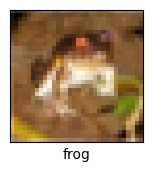

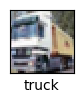

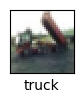

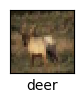

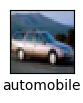

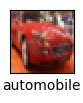

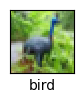

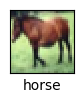

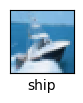

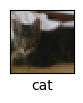

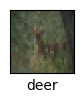

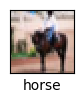

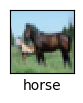

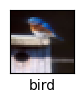

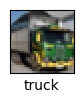

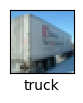

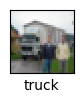

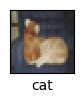

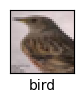

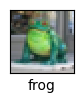

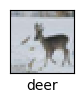

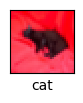

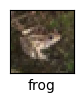

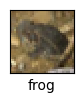

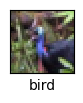

In [3]:
# выберем 25 изображений для визуализации
plt.figure(figsize=(10,10))
for i in range(25):
     plt.subplot(5,5,i+1)
     plt.xticks([])
     plt.yticks([])
     plt.grid(False)
     plt.imshow(train_images[i])
     plt.xlabel(class_names[train_labels[i][0]])
     plt.show()

 Теперь создадим нейросеть из примера. Сначала опишем ее структуру.
 1. На входе тензор размерности (32, 32, 3).
 2. Каждое значение преобразуем в диапазон
[0; 1]
 делением на 255.
 3. Сделаем слой свертки, после чего сделаем слой субдискретизации. Повторим это
 несколько раз.
 4. Вытянем получившийся тензор в вектор.
 5. Создадим полносвязную нейронную сеть.
 6. На выходе будет 10 нейронов без функции активации.
 7. Для получения распределения вероятности.
 Создадим базовую модель со следующими параметрами:
 1. слой свертки:
 размер 3 на 3,
 32 канала,
 шаг (stride) 1 по каждому направлению,
 функция активации
RELU ,
 без дополнения (padding);
 2. слой субдискретизации:
 размер 2 на 2,
 берем максимум,
 с шагом 2 по каждому направлению;
 3. слой свертки:
 размер 3 на 3,
 64 канала,
 шаг (stride) 1 по каждому направлению,
 функция активации
RELU ,
 без дополнения (padding);
 4. слой субдискретизации, такой же как в п. 2;
 5. слой свертки, такой же как в п. 3;
 6. вытягиваем тензор в вектор;
 7. полносвязный слой с 64 нейронами и функцией активации
RELU ;
 8. полносвязный слой с 10 нейронами без функции активации;
 9. функция
softmax .

In [4]:
cnn_model = tf.keras.Sequential([
     # Задаем свертку
     # 32 — количество каналов на выходе
     # (3, 3) — размер окна
     # по умолчанию stride'ы — (1, 1)
     # по умолчанию padding не используется
     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
     # Задаем пулинг
     # (2, 2) — размер окна
     # по умолчанию сдвиг идет на размер окна
     layers.MaxPooling2D((2, 2)),
     layers.Conv2D(64, (3, 3), activation='relu'),
     layers.MaxPooling2D((2, 2)),
     layers.Conv2D(64, (3, 3), activation='relu'),
     # теперь вытянем все в линию
     # на вход подается тензор (32, 32, 3)
     #    — (ширина, высота, каналы)
     # после первой свертки получается (30, 30, 32)
     #    так как размер 3х3 и сдвиг 1х1
     # после 2х2 пулинга остается (15, 15, 32)
     # далее свертка делает (13, 13, 64), потом пулинг
     #    (6, 6, 64) и еще одна свертка
     # делает (4, 4, 64). Это вытягиваем в вектор
     #    длиной 4x4x64 = 1024.
     layers.Flatten(),
     layers.Dense(64, activation='relu'),
     layers.Dense(10),
     layers.Softmax()],
     name = "cnn_model"
     )
cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0 

Чтобы сделать преобработку данных, добавим дополнительный слой.

In [5]:
preprocessing = layers.Rescaling(1 / 255.)

Теперь составим целую модель.

In [6]:
base_model = tf.keras.Sequential([
    preprocessing,
    cnn_model],
    name = "base_model"
)

В качестве функции потерь возьмем перекрестную энтропию для нескольких классов.
 Метки классов в датасете представлены номером класса (от 0 до 9). Для этого можно
 использовать реализацию SparseCategoricalCrossentropy из tensorflow.
 Также будем отслеживать значения точности во время обучения.

In [7]:
base_model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'])

 Теперь запустим обучение модели. Для обучения нужно выбрать количество эпох,
 размер пакета для градиентного спуска.
 Также добавим тестовую выборку для отслеживания качества работы модели.
 Также измерим время обучения модели. Для этого вставим директиву %%time в
 начало ячейки

In [8]:
%%time
base_model_history = base_model.fit(train_images, train_labels, epochs=20,
            validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 13s 5ms/step - loss: 1.5522 - accuracy: 0.4348 - val_loss: 1.3842 - val_accuracy: 0.5023
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1431 - accuracy: 0.5958 - val_loss: 1.1147 - val_accuracy: 0.6068
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9725 - accuracy: 0.6619 - val_loss: 1.1220 - val_accuracy: 0.6221
Epoch 4/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8625 - accuracy: 0.7007 - val_loss: 0.9414 - val_accuracy: 0.6719
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7820 - accuracy: 0.7297 - val_loss: 0.8995 - val_accuracy: 0.6957
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7148 - accuracy: 0.7537 - val_loss: 0.8793 - val_accuracy: 0.7083
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6625 - accuracy: 0.7707 - val_loss: 0.9198 - val_accuracy

 Теперь можем посмотреть информацию о процессе обучения в объекте, который
 вернула функция fit.
 В его поле history лежат значения функции потерь и собранные метрики за каждую
 эпоху.
 Напишем функцию для визуализации этих значений.

In [9]:
 from typing import Dict, List, Tuple
 def plot_history(
    history: Dict[str, List[float]],
    title: str = "",
    metric_name: str = 'loss',
    ylim: Tuple[float, float] = None):

    train_values = history[metric_name]
    plt.plot(train_values, label=f'Train {metric_name}')
    try:
        val_values = history['val_' + metric_name]
        plt.plot(val_values, label=f'Validation {metric_name}')
    except KeyError:
        val_values = []
    plt.title(title)
    all_values = train_values + val_values
    ylim = ylim or (0.9 * min(all_values), 1.1 * max(all_values))
    plt.ylim(ylim)
    plt.ylabel(metric_name.capitalize())
    plt.xlabel("Epoch")
    plt.legend(loc='best')
    plt.show()

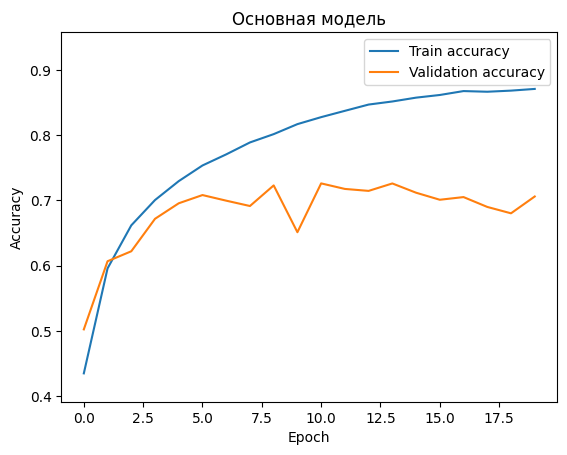

In [10]:
plot_history(base_model_history.history, "Основная модель", "accuracy")

In [11]:
 base_model_history.history['val_accuracy'][-1]

0.7060999870300293

 По графику видно, что модель работает на тренировочной выборке гораздо лучше,чем на тестовой, то есть модель переобучилась

### **Аугментация для модели из примера**

In [12]:
augmentation = tf.keras.Sequential([
    # случайным образом отражаем по горизонтали
    layers.RandomFlip("horizontal"),
    # вращаем на +-18 градусов
    layers.RandomRotation(0.05),
    # изменим контраст на +-20%
    layers.RandomContrast((0.8, 1.2))
    ])

In [13]:
from tensorflow.image import stateless_random_saturation

class RandomSaturation(layers.Layer):
    def __init__(self, lower, upper, seed=None, **kwargs):
        super().__init__(**kwargs)
        self.lower = lower
        self.upper = upper
        self.seed = seed or 0
    def call(self, x, training=True):
        """
        Эта функция реализует отображение этим слоем.
        Используем параметр `training`, чтобы отключить этот
        слой во время использования модели
        """
        if training:
            self.seed += 1
            return stateless_random_saturation(x, self.lower, self.upper, (self.seed, self.seed))
        else:
            return x
# изменяем насыщенность в пределе 50-200%
my_augmentation = RandomSaturation(0.5, 2)

In [14]:
model_w_augmentation = tf.keras.Sequential([
    preprocessing,
    augmentation,
    tf.keras.models.clone_model(cnn_model)],
    name = "model-with-augmentation-1"
)

model_w_augmentation.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model_w_augmentation2 = tf.keras.Sequential([
    preprocessing,
    my_augmentation,
    tf.keras.models.clone_model(cnn_model)],
    name = "model-with-augmentation-2"
)

model_w_augmentation2.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [15]:
%%time
model_aug_history = model_w_augmentation.fit(
    train_images, train_labels, epochs=20,
    validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 13s 7ms/step - loss: 1.7123 - accuracy: 0.3840 - val_loss: 1.5062 - val_accuracy: 0.4698
Epoch 2/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3802 - accuracy: 0.5139 - val_loss: 1.1842 - val_accuracy: 0.5872
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2369 - accuracy: 0.5682 - val_loss: 1.8715 - val_accuracy: 0.4263
Epoch 4/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1573 - accuracy: 0.5966 - val_loss: 1.0757 - val_accuracy: 0.6319
Epoch 5/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1020 - accuracy: 0.6178 - val_loss: 1.0260 - val_accuracy: 0.6478
Epoch 6/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0730 - accuracy: 0.6315 - val_loss: 0.9511 - val_accuracy: 0.6810
Epoch 7/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0504 - accuracy: 0.6394 - val_loss: 0.9706 - val_acc

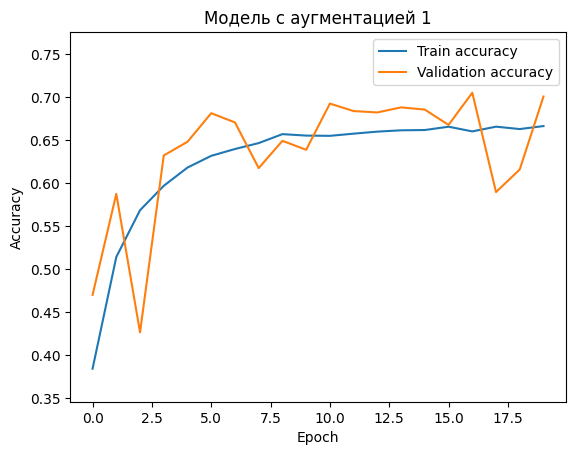

0.7003999948501587

In [16]:
plot_history(model_aug_history.history, "Модель с аугментацией 1", "accuracy")

model_aug_history.history['val_accuracy'][-1]

Epoch 1/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5468 - accuracy: 0.4402 - val_loss: 1.3506 - val_accuracy: 0.5142
Epoch 2/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1631 - accuracy: 0.5899 - val_loss: 1.3185 - val_accuracy: 0.5373
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0042 - accuracy: 0.6475 - val_loss: 1.0493 - val_accuracy: 0.6415
Epoch 4/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.8965 - accuracy: 0.6879 - val_loss: 0.9390 - val_accuracy: 0.6720
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8086 - accuracy: 0.7190 - val_loss: 1.1395 - val_accuracy: 0.6194
Epoch 6/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7381 - accuracy: 0.7439 - val_loss: 1.0247 - val_accuracy: 0.6504
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6858 - accuracy: 0.7628 - val_loss: 0.8641 - val_accuracy

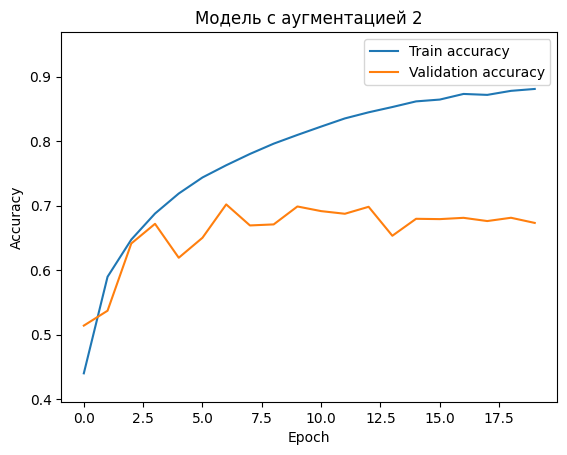

CPU times: user 2min 39s, sys: 11.1 s, total: 2min 50s
Wall time: 3min 23s


0.6733999848365784

In [17]:
%%time
model_aug2_history = model_w_augmentation2.fit(
    train_images, train_labels, epochs=20,
    validation_data=(test_images, test_labels))

plot_history(model_aug2_history.history, "Модель с аугментацией 2", "accuracy")

model_aug2_history.history['val_accuracy'][-1]

## 1 Модель с увеличенной глубиной сети

Добавим в слои сверток два дополнительные слоя свертки с 128 и 256 каналами и окнами (3, 3),а также добавим дополнительный слой MaxPooling2D после новых слоев свертки.

In [18]:
# Увеличенная глубина сети
deeper_cnn_model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
], name="deeper_cnn_model")

deeper_cnn_model.summary()


Model: "deeper_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 128)    

In [19]:
preprocessing = layers.Rescaling(1 / 255.)

deeper_base_model = tf.keras.Sequential([
    preprocessing,
    deeper_cnn_model],
    name="deeper_base_model"
)

deeper_base_model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
%%time
deeper_base_model_history = deeper_base_model.fit(train_images, train_labels, epochs=20,
            validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 12s 6ms/step - loss: 1.5890 - accuracy: 0.4175 - val_loss: 1.1873 - val_accuracy: 0.5783
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0887 - accuracy: 0.6171 - val_loss: 1.0010 - val_accuracy: 0.6531
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8808 - accuracy: 0.6945 - val_loss: 1.0974 - val_accuracy: 0.6453
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7592 - accuracy: 0.7402 - val_loss: 0.9088 - val_accuracy: 0.7078
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7014 - accuracy: 0.7650 - val_loss: 0.8665 - val_accuracy: 0.7244
Epoch 6/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6432 - accuracy: 0.7858 - val_loss: 0.8595 - val_accuracy: 0.7232
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5963 - accuracy: 0.8011 - val_loss: 0.9565 - val_accurac

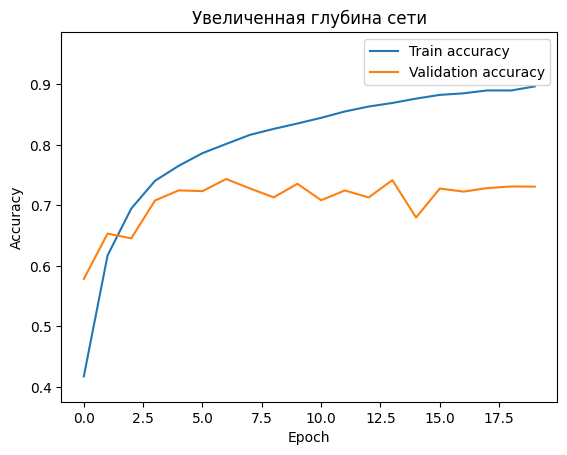

In [21]:
plot_history(deeper_base_model_history.history, "Увеличенная глубина сети", "accuracy")

 По графику видно, что модель работает на тренировочной выборке гораздо лучше,чем на тестовой, то есть модель переобучилась.

In [22]:
deeper_base_model_history.history['val_accuracy'][-1]

0.7305999994277954

точность возросла на 3% по сравнению с базовой моделью

# 2 Модель с меньшим размером сверток

 Уменьшим размер ядер сверток с (3, 3) до (2, 2).

In [23]:
# Меньший размер сверток
smaller_kernels_cnn_model = tf.keras.Sequential([
    layers.Conv2D(32, (2, 2), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10),
    layers.Softmax()],
    name="smaller_kernels_cnn_model"
)
smaller_kernels_cnn_model.summary()

Model: "smaller_kernels_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 31, 31, 32)        416       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 64)          16448     
                                                                 
 flatten_2 (Flatten)         (None, 2304)

In [24]:
preprocessing = layers.Rescaling(1 / 255.)

smaller_kernels_base_model = tf.keras.Sequential([
    preprocessing,
    smaller_kernels_cnn_model],
    name="smaller_kernels_base_model"
)

smaller_kernels_base_model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
%%time
smaller_kernels_base_model_history = smaller_kernels_base_model.fit(train_images, train_labels, epochs=20,
            validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 10s 5ms/step - loss: 1.5088 - accuracy: 0.4580 - val_loss: 1.3363 - val_accuracy: 0.5358
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1082 - accuracy: 0.6084 - val_loss: 1.0625 - val_accuracy: 0.6312
Epoch 3/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9431 - accuracy: 0.6717 - val_loss: 1.0558 - val_accuracy: 0.6301
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8375 - accuracy: 0.7093 - val_loss: 0.8915 - val_accuracy: 0.6948
Epoch 5/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7554 - accuracy: 0.7382 - val_loss: 0.8570 - val_accuracy: 0.7070
Epoch 6/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6940 - accuracy: 0.7583 - val_loss: 0.8239 - val_accuracy: 0.7212
Epoch 7/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6377 - accuracy: 0.7778 - val_loss: 0.8591 - val_accuracy

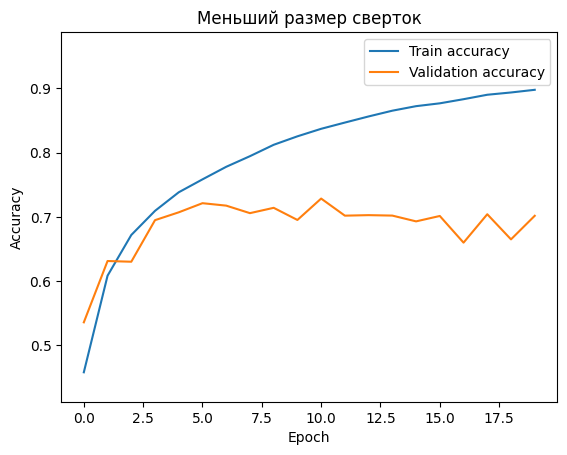

In [26]:
plot_history(smaller_kernels_base_model_history.history, "Меньший размер сверток", "accuracy")

По графику видно, что модель работает на тренировочной выборке гораздо лучше,чем на тестовой, то есть модель переобучилась

In [27]:
smaller_kernels_base_model_history.history['val_accuracy'][-1]

0.7016000151634216

Точность примерно как у базовой

# 3 Модель с увеличенным размер полносвязной сети

Увеличим количество нейронов в первом полносвязном слое с 64 до 256, а также добавим дополнительный полносвязный слой с 128 нейронами.

In [28]:
# Увеличенный размер полносвязной сети
larger_fc_cnn_model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10),
    layers.Softmax()],
    name="larger_fc_cnn_model"
)
larger_fc_cnn_model.summary()

Model: "larger_fc_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 1024)      

In [29]:
preprocessing = layers.Rescaling(1 / 255.)

larger_fc_base_model = tf.keras.Sequential([
    preprocessing,
    larger_fc_cnn_model],
    name="larger_fc_base_model"
)

larger_fc_base_model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
%%time
larger_fc_base_model_history = larger_fc_base_model.fit(train_images, train_labels, epochs=20,
            validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 9s 5ms/step - loss: 1.5452 - accuracy: 0.4396 - val_loss: 1.2085 - val_accuracy: 0.5682
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1137 - accuracy: 0.6072 - val_loss: 1.1032 - val_accuracy: 0.6243
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9354 - accuracy: 0.6733 - val_loss: 1.1688 - val_accuracy: 0.6123
Epoch 4/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8311 - accuracy: 0.7142 - val_loss: 0.8848 - val_accuracy: 0.7047
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7653 - accuracy: 0.7400 - val_loss: 0.9877 - val_accuracy: 0.7052
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7220 - accuracy: 0.7552 - val_loss: 0.9911 - val_accuracy: 0.6890
Epoch 7/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.6985 - accuracy: 0.7650 - val_loss: 1.0308 - val_accuracy:

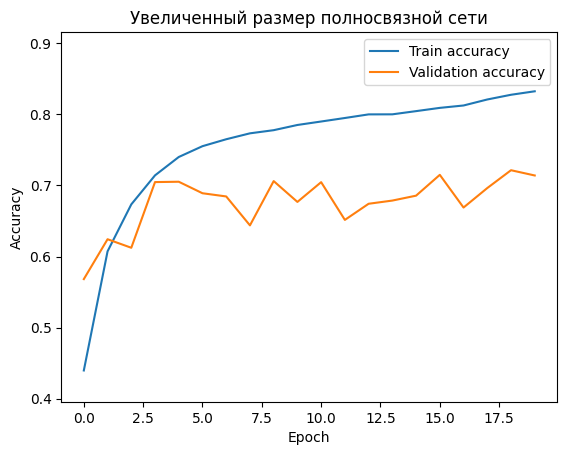

In [31]:
plot_history(larger_fc_base_model_history.history, "Увеличенный размер полносвязной сети", "accuracy")

По графику видно, что модель работает на тренировочной выборке гораздо лучше,чем на тестовой, то есть модель переобучилась

In [32]:
larger_fc_base_model_history.history['val_accuracy'][-1]

0.7139999866485596

Точность, по сравнению с базовой моделью без аугментации возросла на 1%

**Сравнение моделей:**

базовая модель:0.7060 точность 2min 44s времени заняло обучение

1 модель с увеличенной глубиной сети:0.73059 точность, 3min 23s времени заняло обучение

2 модель с меньшим размером сверток:0.7016 точность, 3min 23s времени заняло обучение

3 модель с увеличенным размер полносвязной сети: 0.7139 точность, 2min 33s время обучения

лучшей моделью по точности является первая модель.


## Возьмем первую модель с наибольшой точностью и проверим на ней обучение на данных с аугментацией.

In [33]:
deeper_cnn_model_aug1 = tf.keras.Sequential([
    preprocessing,
    augmentation,
    deeper_cnn_model],
    name = "deeper_cnn_model_aug1"
)

deeper_cnn_model_aug1.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
deeper_cnn_model_aug2 = tf.keras.Sequential([
    preprocessing,
    my_augmentation,
    deeper_cnn_model],
    name = "deeper_cnn_model_aug2"
)

deeper_cnn_model_aug2.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
%%time
deeper_cnn_model_aug1_history = deeper_cnn_model_aug1.fit(
    train_images, train_labels, epochs=20,
    validation_data=(test_images, test_labels))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
Epoch 1/20
1563/1563 [==============================] - 17s 10ms/step - loss: 1.1599 - accuracy: 0.6339 - val_loss: 1.1787 - val_accuracy: 0.6507
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0377 - accuracy: 0.6653 - val_loss: 1.0567 - val_accuracy: 0.7127
Epoch 3/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0287 - accuracy: 0.6689 - val_loss: 1.1915 - val_accuracy: 0.6754
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0182 - accuracy: 0.6694 - val_loss: 1.1818 - val_accuracy: 0.7115
Epoch 5/20
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0083 - accuracy: 0.6742 - val_loss: 0.8607 - val_accuracy: 0.7236
Epoch 6/20
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0117 - accuracy: 0.6721 - val_loss: 1.0081 - val_accuracy: 0.6630
Epoch 7/20
1563/1563 [==============================] - 11s 7ms/s

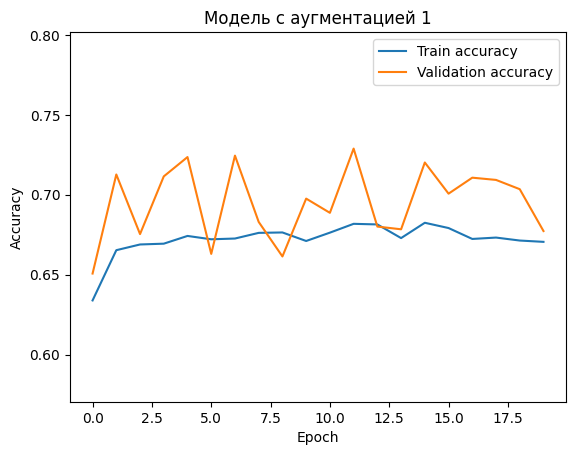

0.677299976348877

In [36]:
plot_history(deeper_cnn_model_aug1_history.history, "Модель с аугментацией 1", "accuracy")

deeper_cnn_model_aug1_history.history['val_accuracy'][-1]

по графику видно что результаты модели на тренировочных данных и на тестовых стали более близкими, это означает что некоторое переобучение удалось устранить, однако точность упала на 6%

In [37]:
%%time
deeper_cnn_model_aug2_history = deeper_cnn_model_aug2.fit(
    train_images, train_labels, epochs=20,
    validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 11s 6ms/step - loss: 0.8579 - accuracy: 0.7367 - val_loss: 1.0218 - val_accuracy: 0.7104
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7946 - accuracy: 0.7535 - val_loss: 0.9418 - val_accuracy: 0.7113
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7595 - accuracy: 0.7659 - val_loss: 0.9572 - val_accuracy: 0.7370
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7298 - accuracy: 0.7709 - val_loss: 0.9230 - val_accuracy: 0.7381
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7319 - accuracy: 0.7799 - val_loss: 1.0210 - val_accuracy: 0.7118
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7089 - accuracy: 0.7813 - val_loss: 0.9163 - val_accuracy: 0.7135
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7036 - accuracy: 0.7879 - val_loss: 1.2372 - val_accuracy

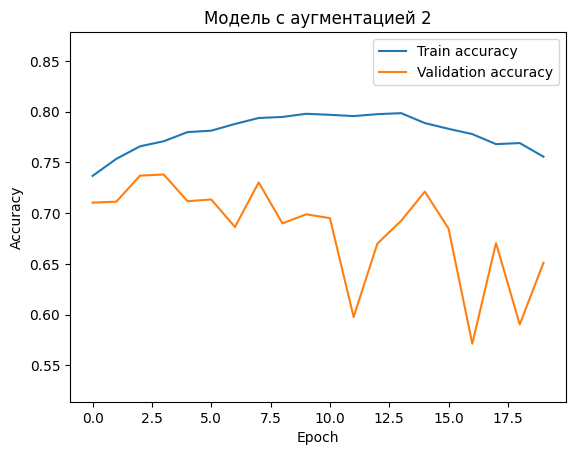

0.6510999798774719

In [38]:
plot_history(deeper_cnn_model_aug2_history.history, "Модель с аугментацией 2", "accuracy")

deeper_cnn_model_aug2_history.history['val_accuracy'][-1]

Вторая аугментация из примера уменьшила точность модели, а также не смогла устронить переобучение.

# 2 Задание

Реализуйте и добавьте другие варианты аугментации

-случайный сдвиг изображения по горизонтали или вертикали;

-перевод изображения из цветного в черно-белое с вероятностью 50%

Обучите наиболее удачную модель из задания 1 с этими аугментациями и сравните результаты

добавим случайный сдвиг на 10%

In [39]:
augmentation1 = tf.keras.Sequential([
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
    ])

In [40]:
preprocessing = layers.Rescaling(1 / 255.)

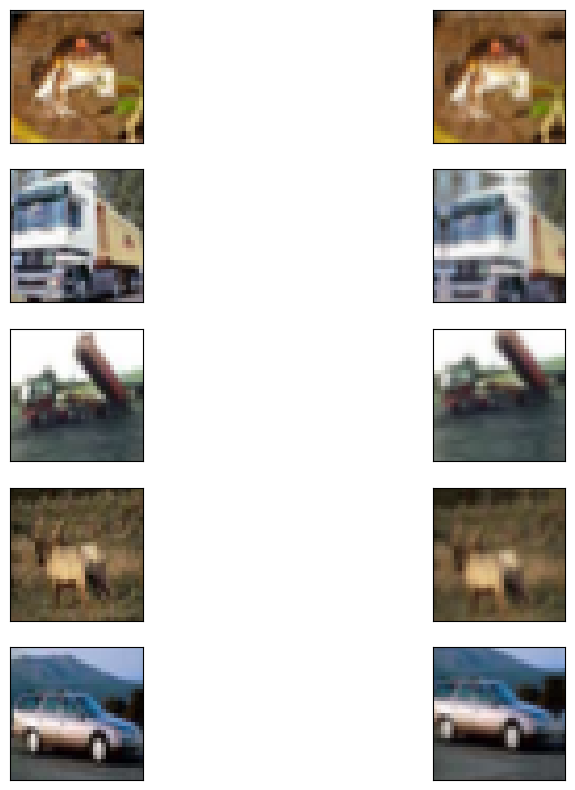

In [41]:
def show_augmentation(augmentation):
  plt.figure(figsize=(10,10))

  for i in range(5):
    original = preprocessing(train_images[i])
    augmented = augmentation(original, training=True)

    plt.subplot(5, 2, 2*i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(original)

    plt.subplot(5, 2, 2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(augmented)

  plt.show()

show_augmentation(augmentation1)

добавим аугментацию для преобразования в чернобелое изображение

In [42]:
class black_white_augmentation(layers.Layer):
    def __init__(self, probability=0.5, **kwargs):
        super().__init__(**kwargs)
        self.probability = probability

    def call(self, inputs, training=True):
      rand = tf.random.uniform([])
      if training and rand < self.probability:
          gray_image = tf.image.rgb_to_grayscale(inputs)
          rgb_image = tf.image.grayscale_to_rgb(gray_image)
          return rgb_image
      else:
          return inputs

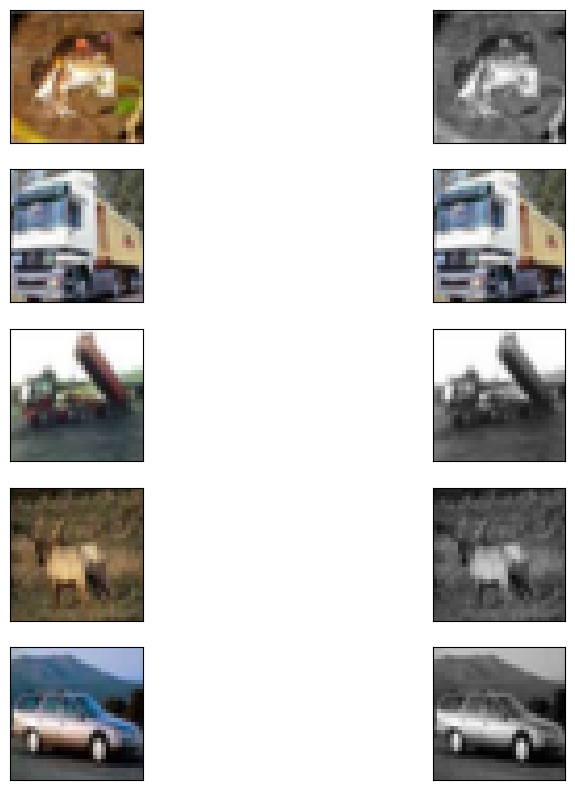

In [43]:
augmentation2 = black_white_augmentation(probability=0.5)
show_augmentation(augmentation2)

Для лучшей модели 1 (с увеличенной глубиной сети) применим аугментацию

In [44]:
deeper_cnn_model_aug1 = tf.keras.Sequential([
    preprocessing,
    augmentation1,
    deeper_cnn_model],
    name = "deeper_cnn_model_aug1"
)

deeper_cnn_model_aug1.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
deeper_cnn_model_aug2 = tf.keras.Sequential([
    preprocessing,
    augmentation2,
    deeper_cnn_model],
    name = "deeper_cnn_model_aug2"
)

deeper_cnn_model_aug2.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
%%time
deeper_cnn_model_aug1_history = deeper_cnn_model_aug1.fit(
    train_images, train_labels, epochs=20,
    validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 12s 7ms/step - loss: 1.5164 - accuracy: 0.5509 - val_loss: 1.8839 - val_accuracy: 0.4976
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6502 - accuracy: 0.5096 - val_loss: 2.0109 - val_accuracy: 0.4596
Epoch 3/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6723 - accuracy: 0.4911 - val_loss: 1.7774 - val_accuracy: 0.4982
Epoch 4/20
1563/1563 [==============================] - 10s 7ms/step - loss: 1.6303 - accuracy: 0.4883 - val_loss: 1.3216 - val_accuracy: 0.5569
Epoch 5/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5565 - accuracy: 0.4979 - val_loss: 1.6219 - val_accuracy: 0.5385
Epoch 6/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5495 - accuracy: 0.5094 - val_loss: 1.4605 - val_accuracy: 0.4997
Epoch 7/20
1563/1563 [==============================] - 10s 7ms/step - loss: 1.5900 - accuracy: 0.4995 - val_loss: 1.5503 - val_accu

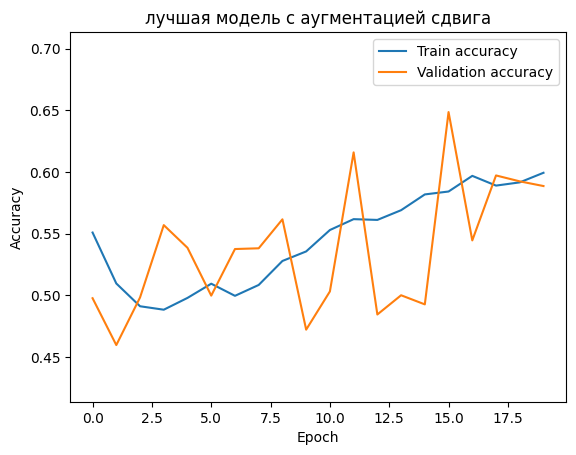

0.5885999798774719

In [50]:
plot_history(deeper_cnn_model_aug1_history.history, "лучшая модель с аугментацией сдвига", "accuracy")

deeper_cnn_model_aug1_history.history['val_accuracy'][-1]

аугментация сдивга сильно понизила точность модели, сильного переобучения не наблюдается.

In [51]:
%%time
deeper_cnn_model_aug2_history = deeper_cnn_model_aug2.fit(
    train_images, train_labels, epochs=20,
    validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 12s 7ms/step - loss: 1.3432 - accuracy: 0.5996 - val_loss: 1.2835 - val_accuracy: 0.6199
Epoch 2/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3242 - accuracy: 0.6112 - val_loss: 1.9112 - val_accuracy: 0.5612
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3561 - accuracy: 0.6067 - val_loss: 1.2799 - val_accuracy: 0.6128
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2994 - accuracy: 0.6179 - val_loss: 1.6063 - val_accuracy: 0.6042
Epoch 5/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3293 - accuracy: 0.6142 - val_loss: 1.9770 - val_accuracy: 0.5626
Epoch 6/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3357 - accuracy: 0.6194 - val_loss: 3.3836 - val_accuracy: 0.5249
Epoch 7/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3123 - accuracy: 0.6207 - val_loss: 2.0723 - val_accu

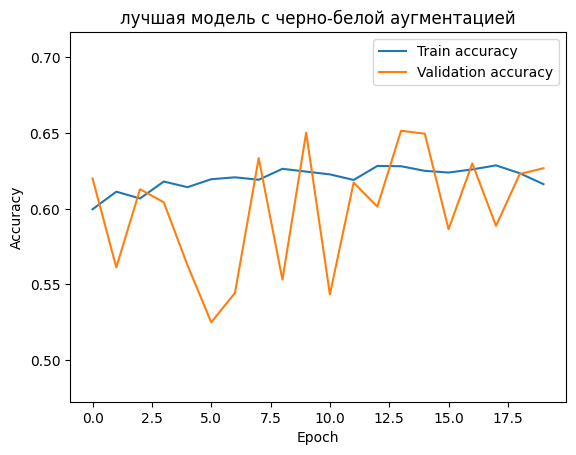

0.6266999840736389

In [52]:
plot_history(deeper_cnn_model_aug2_history.history, "лучшая модель с черно-белой аугментацией", "accuracy")

deeper_cnn_model_aug2_history.history['val_accuracy'][-1]

Вывод: обе аугментации понизили точность модели,но и немного снизили эффект переобучениея. Однако точность без аугментации гораздо больше, значит для этой модели данные виды аугментации скорее не подходят

# Задание 3

Реализуйте сверточную нейронную сеть для классификации изображений из
 набора данных CIFAR-100. Попробуйте несколько разных нейросетей для
 классификации. Оцените для них количество параметров, время обучения.
 Отметьте, было ли переобучение сети.

In [19]:
cifar100 = tf.keras.datasets.cifar100
(train_images, train_labels), (test_images, test_labels) = \
 datasets.cifar100.load_data()
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',
    'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster',
    'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange',
    'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy',
    'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal',
    'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar',
    'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

In [20]:
cnn_model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(100),
    layers.Softmax()],
    name = "cnn_model"
)
cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_77 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_78 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0 

In [21]:
preprocessing = layers.Rescaling(1 / 255.)

In [22]:
base_model = tf.keras.Sequential([
    preprocessing,
    cnn_model],
    name = "base_model"
)

In [23]:
base_model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [24]:
base_model_history = base_model.fit(train_images, train_labels, epochs=20,
 validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 10s 6ms/step - loss: 4.0042 - accuracy: 0.0894 - val_loss: 3.6080 - val_accuracy: 0.1539
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 3.3244 - accuracy: 0.1996 - val_loss: 3.1213 - val_accuracy: 0.2351
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 2.9867 - accuracy: 0.2652 - val_loss: 2.9223 - val_accuracy: 0.2776
Epoch 4/20
1563/1563 [==============================] - 7s 4ms/step - loss: 2.7517 - accuracy: 0.3107 - val_loss: 2.8727 - val_accuracy: 0.2907
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 2.5741 - accuracy: 0.3453 - val_loss: 2.7051 - val_accuracy: 0.3276
Epoch 6/20
1563/1563 [==============================] - 7s 5ms/step - loss: 2.4410 - accuracy: 0.3762 - val_loss: 2.6517 - val_accuracy: 0.3411
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 2.3249 - accuracy: 0.3983 - val_loss: 2.9929 - val_accuracy

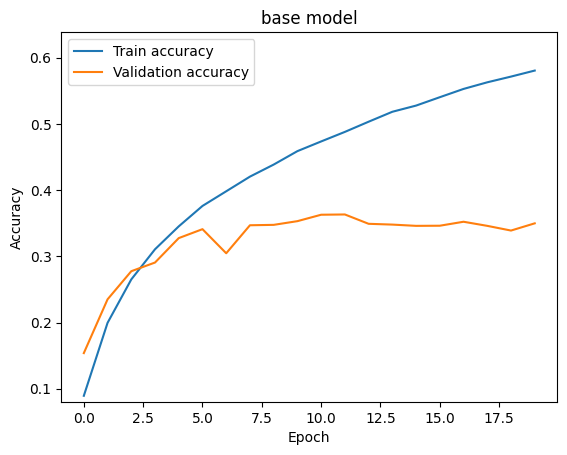

0.3499000072479248

In [25]:
plot_history(base_model_history.history, "base model", "accuracy")

base_model_history.history['val_accuracy'][-1]

In [47]:
cnn_model_2 = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')
], name='cnn_model_2')


cnn_model_2.summary()


Model: "cnn_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_182 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_69 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_183 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_70 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                       

In [48]:
preprocessing = layers.Rescaling(1 / 255.)

In [49]:
base_model_2 = tf.keras.Sequential([
    preprocessing,
    cnn_model_2],
    name = "model-2"
)

In [50]:
base_model_2.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [51]:
%%time
base_model_2_history = base_model_2.fit(train_images, train_labels, epochs=20,
 validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 21s 11ms/step - loss: 4.1357 - accuracy: 0.0970 - val_loss: 3.3614 - val_accuracy: 0.1965
Epoch 2/20
1563/1563 [==============================] - 17s 11ms/step - loss: 3.2482 - accuracy: 0.2219 - val_loss: 2.8172 - val_accuracy: 0.3042
Epoch 3/20
1563/1563 [==============================] - 17s 11ms/step - loss: 2.8564 - accuracy: 0.2990 - val_loss: 2.4953 - val_accuracy: 0.3656
Epoch 4/20
1563/1563 [==============================] - 24s 15ms/step - loss: 2.6307 - accuracy: 0.3454 - val_loss: 2.3637 - val_accuracy: 0.3981
Epoch 5/20
1563/1563 [==============================] - 16s 10ms/step - loss: 2.4616 - accuracy: 0.3830 - val_loss: 2.2560 - val_accuracy: 0.4236
Epoch 6/20
1563/1563 [==============================] - 19s 12ms/step - loss: 2.3335 - accuracy: 0.4131 - val_loss: 2.0543 - val_accuracy: 0.4600
Epoch 7/20
1563/1563 [==============================] - 17s 11ms/step - loss: 2.2311 - accuracy: 0.4350 - val_loss: 2.0332 -

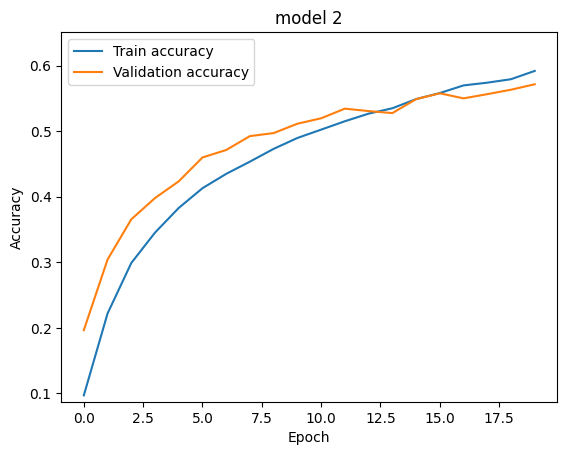

0.5716999769210815

In [53]:
plot_history(base_model_2_history.history, "model 2", "accuracy")

base_model_2_history.history['val_accuracy'][-1]

In [54]:
cnn_model_3 = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')
], name='cnn_model_3')


cnn_model_3.summary()


Model: "cnn_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_190 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_78 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_191 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_79 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                       

In [55]:
preprocessing = layers.Rescaling(1 / 255.)

In [56]:
base_model_3 = tf.keras.Sequential([
    preprocessing,
    cnn_model_3],
    name = "model-3"
)

In [57]:
base_model_3.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [58]:
%%time
base_model_3_history = base_model_3.fit(train_images, train_labels, epochs=20,
 validation_data=(test_images, test_labels))

Epoch 1/20
1563/1563 [==============================] - 26s 14ms/step - loss: 3.9275 - accuracy: 0.1399 - val_loss: 2.8846 - val_accuracy: 0.2949
Epoch 2/20
1563/1563 [==============================] - 23s 14ms/step - loss: 2.8549 - accuracy: 0.3031 - val_loss: 2.4219 - val_accuracy: 0.3951
Epoch 3/20
1563/1563 [==============================] - 23s 15ms/step - loss: 2.4920 - accuracy: 0.3791 - val_loss: 2.1078 - val_accuracy: 0.4578
Epoch 4/20
1563/1563 [==============================] - 21s 14ms/step - loss: 2.2886 - accuracy: 0.4262 - val_loss: 1.9987 - val_accuracy: 0.4837
Epoch 5/20
1563/1563 [==============================] - 22s 14ms/step - loss: 2.1418 - accuracy: 0.4560 - val_loss: 1.8675 - val_accuracy: 0.5221
Epoch 6/20
1563/1563 [==============================] - 22s 14ms/step - loss: 2.0232 - accuracy: 0.4853 - val_loss: 1.8395 - val_accuracy: 0.5254
Epoch 7/20
1563/1563 [==============================] - 22s 14ms/step - loss: 1.9215 - accuracy: 0.5070 - val_loss: 1.7938 -

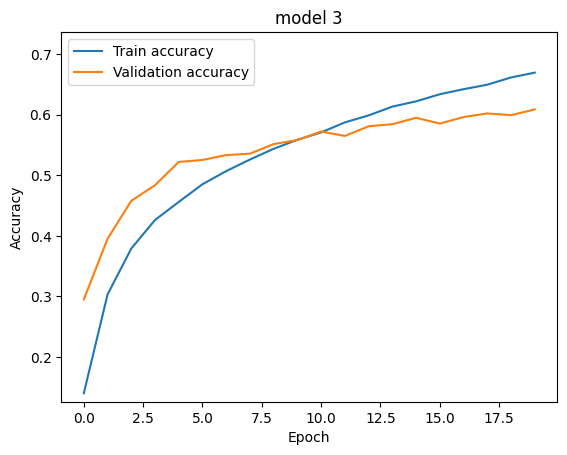

0.6089000105857849

In [61]:
plot_history(base_model_3_history.history, "model 3", "accuracy")

base_model_3_history.history['val_accuracy'][-1]

**Результаты:**

1 модель (0.3499), параметров (128420), переобучение наблюдается

2 модель точность (0.5716), параметров (1462788), время обучения:7min 24s, переобучения не наблюдается

3 модель: точность (0.6089), параметров (3297188), время обучения:7min 24s, переобучения не наблюдается

3 модель является лучшей из представленных

# Задание 4

Реализуйте сверточную нейронную сеть для классификации для набора данных
 17 Category Flower Dataset. Попробуйте несколько разных нейросетей для
 классификации. Оцените для них количество параметров, время обучения.
 Отметьте, было ли переобучение сети.

In [74]:
import shutil
from more_itertools import chunked
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os

загрузим данный

In [75]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
!tar -zxf 17flowers.tgz

URL transformed to HTTPS due to an HSTS policy
--2024-05-27 01:21:04--  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-17/17flowers.tgz [following]
--2024-05-27 01:21:05--  https://thor.robots.ox.ac.uk/datasets/flowers-17/17flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60270631 (57M) [application/octet-stream]
Saving to: ‘17flowers.tgz.2’

17flowers.tgz.2     100%[===================>]  57.48M  25.2MB/s    in 2.3s    

2024-05-27 01:21:08 (25.2 MB/s) - ‘17flowers.tgz.2’ saved [60270631/60270631]



In [77]:
_files = os.listdir("jpg")
_files = sorted([x for x in _files if x.endswith(".jpg")])

grouped_files = list(chunked(_files,80))


parent_dir = "image"
if os.path.exists(parent_dir) == False:
    os.mkdir(parent_dir)


labels = ['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary', 'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']
for label in labels:
    subfolder = os.path.join(parent_dir,label)
    if os.path.exists(subfolder) == False:
        os.mkdir(subfolder)

for i,files in enumerate(grouped_files):
    for file in files:
        orig = os.path.join("jpg",file)
        dest = os.path.join(parent_dir,labels[i],file)
        shutil.copy2(orig,dest)

x = []
y = []

for i,label in enumerate(labels):
    folder = os.path.join("image",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        img_path = os.path.join(folder,file)
        img = load_img(img_path,target_size=(256,256))
        x.append(img)
        y.append(i)

x = np.array(x)
y = np.array(y)
y = to_categorical(y)

train_images, test_images, train_labels, test_labels = train_test_split(x,y,random_state=42,test_size=0.2)

print(train_images.shape,train_labels.shape)
print(test_images.shape,test_labels.shape)

(1088, 256, 256, 3) (1088, 17)
(272, 256, 256, 3) (272, 17)


In [78]:
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

Возьмем архитектуры моделей из первого задания и проверим как они покажут себя на представленных данных

1 модель

In [79]:
deeper_cnn_model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(17, activation='softmax')
], name="deeper_cnn_model")

deeper_cnn_model.summary()


Model: "deeper_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_196 (Conv2D)         (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_197 (Conv2D)         (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_198 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 32, 32, 128)  

In [81]:
deeper_base_model = tf.keras.Sequential([
    preprocessing,
    deeper_cnn_model],
    name="deeper_base_model"
)

deeper_base_model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
%%time
deeper_base_model_history = deeper_base_model.fit(train_images, train_labels, epochs=20,
            validation_data=(test_images, test_labels))

Epoch 1/20
34/34 [==============================] - 11s 109ms/step - loss: 3.0413 - accuracy: 0.0938 - val_loss: 2.6191 - val_accuracy: 0.1397
Epoch 2/20
34/34 [==============================] - 3s 80ms/step - loss: 2.3505 - accuracy: 0.1958 - val_loss: 2.4152 - val_accuracy: 0.1838
Epoch 3/20
34/34 [==============================] - 3s 77ms/step - loss: 2.0753 - accuracy: 0.3033 - val_loss: 2.0124 - val_accuracy: 0.3015
Epoch 4/20
34/34 [==============================] - 3s 83ms/step - loss: 1.8928 - accuracy: 0.3585 - val_loss: 2.0583 - val_accuracy: 0.2610
Epoch 5/20
34/34 [==============================] - 3s 81ms/step - loss: 1.6364 - accuracy: 0.4256 - val_loss: 2.1862 - val_accuracy: 0.3456
Epoch 6/20
34/34 [==============================] - 3s 77ms/step - loss: 1.3112 - accuracy: 0.5597 - val_loss: 1.7060 - val_accuracy: 0.4412
Epoch 7/20
34/34 [==============================] - 3s 77ms/step - loss: 0.9222 - accuracy: 0.7013 - val_loss: 1.7557 - val_accuracy: 0.4559
Epoch 8/20


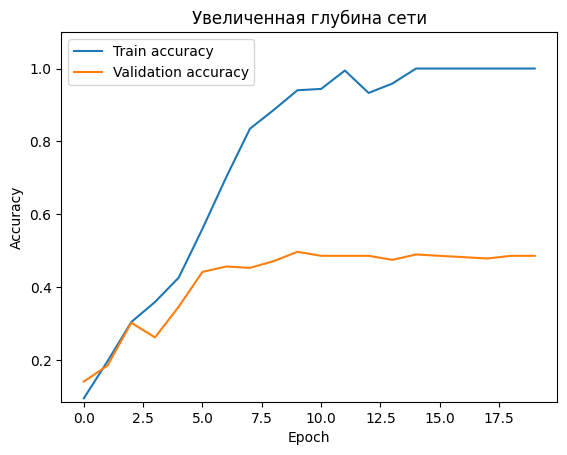

In [83]:
plot_history(deeper_base_model_history.history, "Увеличенная глубина сети", "accuracy")

In [84]:
deeper_base_model_history.history['val_accuracy'][-1]

0.4852941036224365

2 модель

In [86]:
# Меньший размер сверток
smaller_kernels_cnn_model = tf.keras.Sequential([
    layers.Conv2D(32, (2, 2), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(17),
    layers.Softmax()],
    name="smaller_kernels_cnn_model"
)
smaller_kernels_cnn_model.summary()

Model: "smaller_kernels_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_201 (Conv2D)         (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_202 (Conv2D)         (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_203 (Conv2D)         (None, 62, 62, 64)        16448     
                                                                 
 flatten_12 (Flatten)        (None, 24601

In [87]:
smaller_kernels_base_model = tf.keras.Sequential([
    preprocessing,
    smaller_kernels_cnn_model],
    name="smaller_kernels_base_model"
)

smaller_kernels_base_model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [88]:
%%time
smaller_kernels_base_model_history = smaller_kernels_base_model.fit(train_images, train_labels, epochs=20,
            validation_data=(test_images, test_labels))

Epoch 1/20
34/34 [==============================] - 5s 73ms/step - loss: 3.5060 - accuracy: 0.1682 - val_loss: 2.1870 - val_accuracy: 0.2574
Epoch 2/20
34/34 [==============================] - 2s 54ms/step - loss: 2.0097 - accuracy: 0.3263 - val_loss: 2.4440 - val_accuracy: 0.2463
Epoch 3/20
34/34 [==============================] - 2s 55ms/step - loss: 1.5164 - accuracy: 0.5248 - val_loss: 1.6480 - val_accuracy: 0.4228
Epoch 4/20
34/34 [==============================] - 2s 64ms/step - loss: 0.9325 - accuracy: 0.7105 - val_loss: 2.1047 - val_accuracy: 0.4191
Epoch 5/20
34/34 [==============================] - 2s 62ms/step - loss: 0.5828 - accuracy: 0.8235 - val_loss: 1.6383 - val_accuracy: 0.5000
Epoch 6/20
34/34 [==============================] - 2s 53ms/step - loss: 0.2503 - accuracy: 0.9292 - val_loss: 1.7059 - val_accuracy: 0.5110
Epoch 7/20
34/34 [==============================] - 2s 53ms/step - loss: 0.1392 - accuracy: 0.9660 - val_loss: 1.7405 - val_accuracy: 0.5404
Epoch 8/20
34

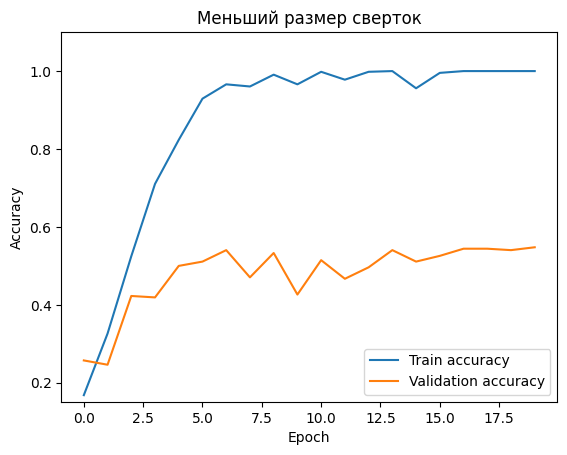

In [89]:
plot_history(smaller_kernels_base_model_history.history, "Меньший размер сверток", "accuracy")

In [90]:
smaller_kernels_base_model_history.history['val_accuracy'][-1]

0.5477941036224365

3 модель

In [91]:
# Увеличенный размер полносвязной сети
larger_fc_cnn_model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(17),
    layers.Softmax()],
    name="larger_fc_cnn_model"
)
larger_fc_cnn_model.summary()

Model: "larger_fc_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_204 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_205 (Conv2D)         (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_206 (Conv2D)         (None, 60, 60, 64)        36928     
                                                                 
 flatten_13 (Flatten)        (None, 230400)    

In [92]:

larger_fc_base_model = tf.keras.Sequential([
    preprocessing,
    larger_fc_cnn_model],
    name="larger_fc_base_model"
)

larger_fc_base_model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [93]:
%%time
larger_fc_base_model_history = larger_fc_base_model.fit(train_images, train_labels, epochs=20,
            validation_data=(test_images, test_labels))

Epoch 1/20
34/34 [==============================] - 7s 93ms/step - loss: 4.0635 - accuracy: 0.0965 - val_loss: 2.4162 - val_accuracy: 0.1691
Epoch 2/20
34/34 [==============================] - 2s 67ms/step - loss: 2.3995 - accuracy: 0.2252 - val_loss: 1.9338 - val_accuracy: 0.3382
Epoch 3/20
34/34 [==============================] - 2s 73ms/step - loss: 1.8540 - accuracy: 0.3814 - val_loss: 2.2115 - val_accuracy: 0.3015
Epoch 4/20
34/34 [==============================] - 2s 71ms/step - loss: 1.3974 - accuracy: 0.5414 - val_loss: 1.5519 - val_accuracy: 0.4559
Epoch 5/20
34/34 [==============================] - 2s 66ms/step - loss: 1.0838 - accuracy: 0.6599 - val_loss: 2.3075 - val_accuracy: 0.3897
Epoch 6/20
34/34 [==============================] - 2s 63ms/step - loss: 0.5773 - accuracy: 0.8235 - val_loss: 2.8187 - val_accuracy: 0.2610
Epoch 7/20
34/34 [==============================] - 2s 67ms/step - loss: 0.3107 - accuracy: 0.9062 - val_loss: 2.2445 - val_accuracy: 0.4632
Epoch 8/20
34

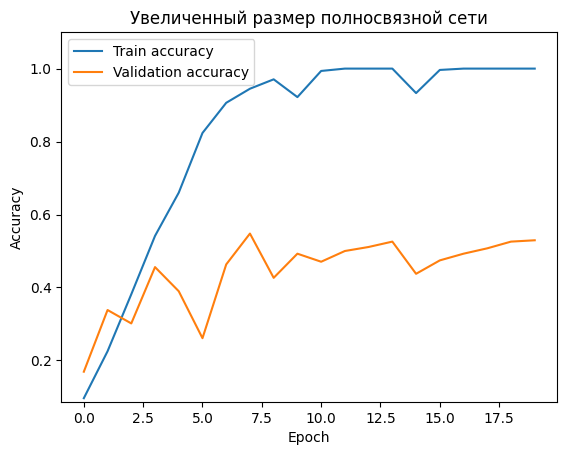

In [94]:
plot_history(larger_fc_base_model_history.history, "Увеличенный размер полносвязной сети", "accuracy")

In [95]:
larger_fc_base_model_history.history['val_accuracy'][-1]

0.529411792755127

Результат:
Если сравнивать с данными из первого задания точность моделей с представленными разными архитектурами на этих данных снизилась( однако количество классов у нас также увеличилось и сами данные изменились).

Сравним модели между собой
1 модель(Увеличенная глубина сети) точность:(0.4852), параметров (17760337), время обучения: 1min 24s, переобучение наблюдается

2 модель (меньший размер сверток) точность (0.5477), параметров (15771313), время обучения:42.1 s, переобучения наблюдается

3 модель (увеличенный равзмер полносвязной сети): точность (0.5294), параметров (59074065), время обучения:1min 23s, переобучения наблюдается

Так как из за понижения точности не была применена аугментация мы наблюдаем переобучение во всех моделях.

2 модель с меньшим размером ядра свертки является лучшей из представленных с наибольшей точностью. В первом же задании лабораторной побеждала 1 модель
